In [2]:
import os
import tensorflow as tf
# import kaggle
from PIL import Image
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import hashlib
from tensorflow.keras import Sequential,layers,Input,optimizers,utils,callbacks,metrics
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
# from google.colab import drive
import tensorflow as tf
import numpy as np
import shutil
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, balanced_accuracy_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
import torch
import timm
import torch.nn as nn
from torchvision import datasets, transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
from transformers import ViTForImageClassification, AutoImageProcessor,AutoProcessor, AutoModelForImageClassification
import requests
from io import BytesIO


# 0. Directory preparation
This part is used to organize the directory that fit for our model training including lables, train,validation datasets.The directory is organized base on our binary classification dataset.(../merged_data)

we transfered data from merged_data and re-organized it to fit our mult-class training.

If you alrady excute this part once, the folder will be generated in your environment then you dont need to do it twice.

Merge_data dataset from binary classifcation is a clean the dataset which dont include invalid, small, not RGB and duplicate picture, so we dont need to do sanity check again.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
available_datasets = ['imagenet_glide', 'imagenet_midjourney', 'imagenet_ai_0424_wukong', 'imagenet_ai_0508_adm', 'imagenet_ai_0424_sdv5', 'imagenet_ai_0419_vqdm', 'imagenet_ai_0419_biggan']
datasets_name = [dataset.split("_")[-1] for dataset in available_datasets]
merge_path = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/dataset_multiclass'
source_path = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data'
stats = {
    'train':{'glide': 0, 'midjourney':0, 'wukong':0, 'adm':0 , 'sdv5': 0 , 'vqdm':0, 'biggan': 0},
    'val':{'glide': 0, 'midjourney':0, 'wukong':0, 'adm':0 , 'sdv5': 0 , 'vqdm':0, 'biggan': 0}
    }

In [ ]:
# ...existing code...
merge_path = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/dataset_multiclass'
source_path = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data'
stats = {
    'train':{'glide': 0, 'midjourney':0, 'wukong':0, 'adm':0 , 'sdv5': 0 , 'vqdm':0, 'biggan': 0},
    'val':{'glide': 0, 'midjourney':0, 'wukong':0, 'adm':0 , 'sdv5': 0 , 'vqdm':0, 'biggan': 0}
    }

for split in ['train','val']:
    for class_name in ['ai','nature']:
        if class_name == 'ai':
            class_path = os.path.join(source_path, split, class_name)
            if not os.path.exists(class_path):
                continue


            target_path = os.path.join(merge_path, split)
            for dataset in datasets_name:

                target_dataset_class_path = os.path.join(target_path, dataset)
                os.makedirs(target_dataset_class_path, exist_ok=True)

                for img_file in os.listdir(class_path):
                    if dataset in img_file.lower() and img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        src_file = os.path.join(class_path, img_file)
                        dst_file = os.path.join(target_dataset_class_path, img_file)
                        if os.path.exists(dst_file):
                            continue

                        shutil.copy2(src_file, dst_file)

                        stats[split].setdefault(dataset, 0)
                        stats[split][dataset] += 1

# 1. Configuration

In [23]:
# ---- config ----
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "google/vit-base-patch16-224"
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-5
WEIGHT_DECAY = 0.01
train_dir = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/dataset_multiclass/train'
val_dir ='/content/drive/MyDrive/Colab Notebooks/AI_vs_human/dataset_multiclass/val'
BEST_DIR = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit'


In [ ]:
DEVICE

device(type='cuda')

# 2. Preprocess datasets

In [34]:
# ---- processor (get correct mean/std) ----
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
mean = processor.image_mean
std = processor.image_std

# ---- Transforms for datasets ----
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.9, 1.0),
        ratio=(0.9, 1.1)
    ),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.1,
        hue=0.02
    ),

    transforms.RandomRotation(3),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
val_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 256 / 224)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


# 3. Load datasets

In [36]:
# ---- datasets ----
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)
print("class_to_idx:", train_ds.class_to_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Classes: ['adm', 'biggan', 'glide', 'midjourney', 'sdv5', 'vqdm', 'wukong']
class_to_idx: {'adm': 0, 'biggan': 1, 'glide': 2, 'midjourney': 3, 'sdv5': 4, 'vqdm': 5, 'wukong': 6}


# 4. Initialize Model

In [ ]:
# ---- model ---
# label2id / id2label
id2label = {id: label for id, label in enumerate(train_ds.classes)}
label2id = {label: id for id, label in enumerate(train_ds.classes)}
print("id2label:", id2label)
print("label2id:", label2id)

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 让分类头自动重建
).to(DEVICE)

#  freeze all layer
for param in model.parameters():
    param.requires_grad = False

#  unfreeze last 5 layer
for param in model.vit.encoder.layer[-10:].parameters():
    param.requires_grad = True

#  Unfreeze header
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

# optimizer initializatioin
optimizer = AdamW([
    {"params": model.classifier.parameters(), "lr": 3e-5},
    {"params": model.vit.encoder.layer[-10:].parameters(), "lr": 1e-5},
], weight_decay=0.01)


from transformers import get_cosine_schedule_with_warmup

total_steps = len(train_loader) * EPOCHS

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print("Trainable params:", trainable)
print("Total params:", total)
print("Trainable %:", 100 * trainable / total)

id2label: {0: 'adm', 1: 'biggan', 2: 'glide', 3: 'midjourney', 4: 'sdv5', 5: 'vqdm', 6: 'wukong'}
label2id: {'adm': 0, 'biggan': 1, 'glide': 2, 'midjourney': 3, 'sdv5': 4, 'vqdm': 5, 'wukong': 6}


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([7])          
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 768]) vs model:torch.Size([7, 768])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


# 5. Train the model and check the accuracy and loss curve for tran and val datasets

In [ ]:
print("\n" + "="*60)
print("TRAINING................")
print("="*60)

train_losses = []
train_accs = []
val_accs = []
val_losses = []

patience = 3
best_val_acc = float("-inf")
best_val_loss = float("inf")
best_epoch = 0
wait = 0

os.makedirs(BEST_DIR, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # Training
    model.train()
    train_correct = 0
    train_total = 0
    train_loss_sum = 0.0  # 按样本加权累计

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(DEVICE, non_blocking=True)
        batch_y = batch_y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(pixel_values=batch_X)
        logits = outputs.logits

        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        scheduler.step()

        bs = batch_X.size(0)
        train_loss_sum += loss.item() * bs

        preds = logits.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += bs

    train_acc = train_correct / train_total
    avg_train_loss = train_loss_sum / train_total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(DEVICE, non_blocking=True)
            batch_y = batch_y.to(DEVICE, non_blocking=True)

            outputs = model(pixel_values=batch_X)
            logits = outputs.logits

            loss = criterion(logits, batch_y)

            bs = batch_X.size(0)
            val_loss_sum += loss.item() * bs

            preds = logits.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += bs

    val_acc = val_correct / val_total
    avg_val_loss = val_loss_sum / val_total

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch}/{EPOCHS} - Time: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")

    # save best model (based on val_acc)
    improved = avg_val_loss < best_val_loss - 1e-6
    if improved:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        wait = 0
        model.save_pretrained(BEST_DIR)
        processor.save_pretrained(BEST_DIR)
        print(f"best epoch updated to {best_epoch}")
        print(f"best validation loss updated to {best_val_loss:.4f}")
        print(f"best model saved at path {BEST_DIR}")
    else:
        wait += 1
        print(f"val loss did not improve (wait={wait}/{patience})")  # ✅ 文案修正

    # early stop
    if wait >= patience:
        print(f"Early stopping at epoch {epoch}")
        print(f"Best epoch: {best_epoch}")
        print(f"Best val loss: {best_val_loss:.4f}")  # ✅ 修正
        break

print("\n✓ Training complete!")


TRAINING................

Epoch 1/10 - Time: 226.7s (3.8 min)
  Train - Loss: 1.7550, Acc: 0.2997 (29.97%)
  Val   - Loss: 1.1117, Acc: 0.6114 (61.14%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 1
best validation loss updated to 1.1117
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 2/10 - Time: 221.3s (3.7 min)
  Train - Loss: 0.5723, Acc: 0.7898 (78.98%)
  Val   - Loss: 0.5098, Acc: 0.8086 (80.86%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 2
best validation loss updated to 0.5098
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 3/10 - Time: 220.6s (3.7 min)
  Train - Loss: 0.3185, Acc: 0.8818 (88.18%)
  Val   - Loss: 0.4220, Acc: 0.8363 (83.63%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 3
best validation loss updated to 0.4220
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 4/10 - Time: 221.6s (3.7 min)
  Train - Loss: 0.2180, Acc: 0.9214 (92.14%)
  Val   - Loss: 0.3873, Acc: 0.8506 (85.06%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 4
best validation loss updated to 0.3873
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 5/10 - Time: 221.6s (3.7 min)
  Train - Loss: 0.1443, Acc: 0.9514 (95.14%)
  Val   - Loss: 0.3833, Acc: 0.8534 (85.34%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 5
best validation loss updated to 0.3833
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 6/10 - Time: 221.1s (3.7 min)
  Train - Loss: 0.1050, Acc: 0.9694 (96.94%)
  Val   - Loss: 0.3769, Acc: 0.8611 (86.11%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 6
best validation loss updated to 0.3769
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 7/10 - Time: 221.5s (3.7 min)
  Train - Loss: 0.0775, Acc: 0.9782 (97.82%)
  Val   - Loss: 0.3834, Acc: 0.8589 (85.89%)
val loss did not improve (wait=1/3)

Epoch 8/10 - Time: 215.6s (3.6 min)
  Train - Loss: 0.0593, Acc: 0.9851 (98.51%)
  Val   - Loss: 0.3807, Acc: 0.8611 (86.11%)
val loss did not improve (wait=2/3)

Epoch 9/10 - Time: 215.3s (3.6 min)
  Train - Loss: 0.0513, Acc: 0.9884 (98.84%)
  Val   - Loss: 0.3839, Acc: 0.8600 (86.00%)
val loss did not improve (wait=3/3)
Early stopping at epoch 9
Best epoch: 6
Best val loss: 0.3769

✓ Training complete!


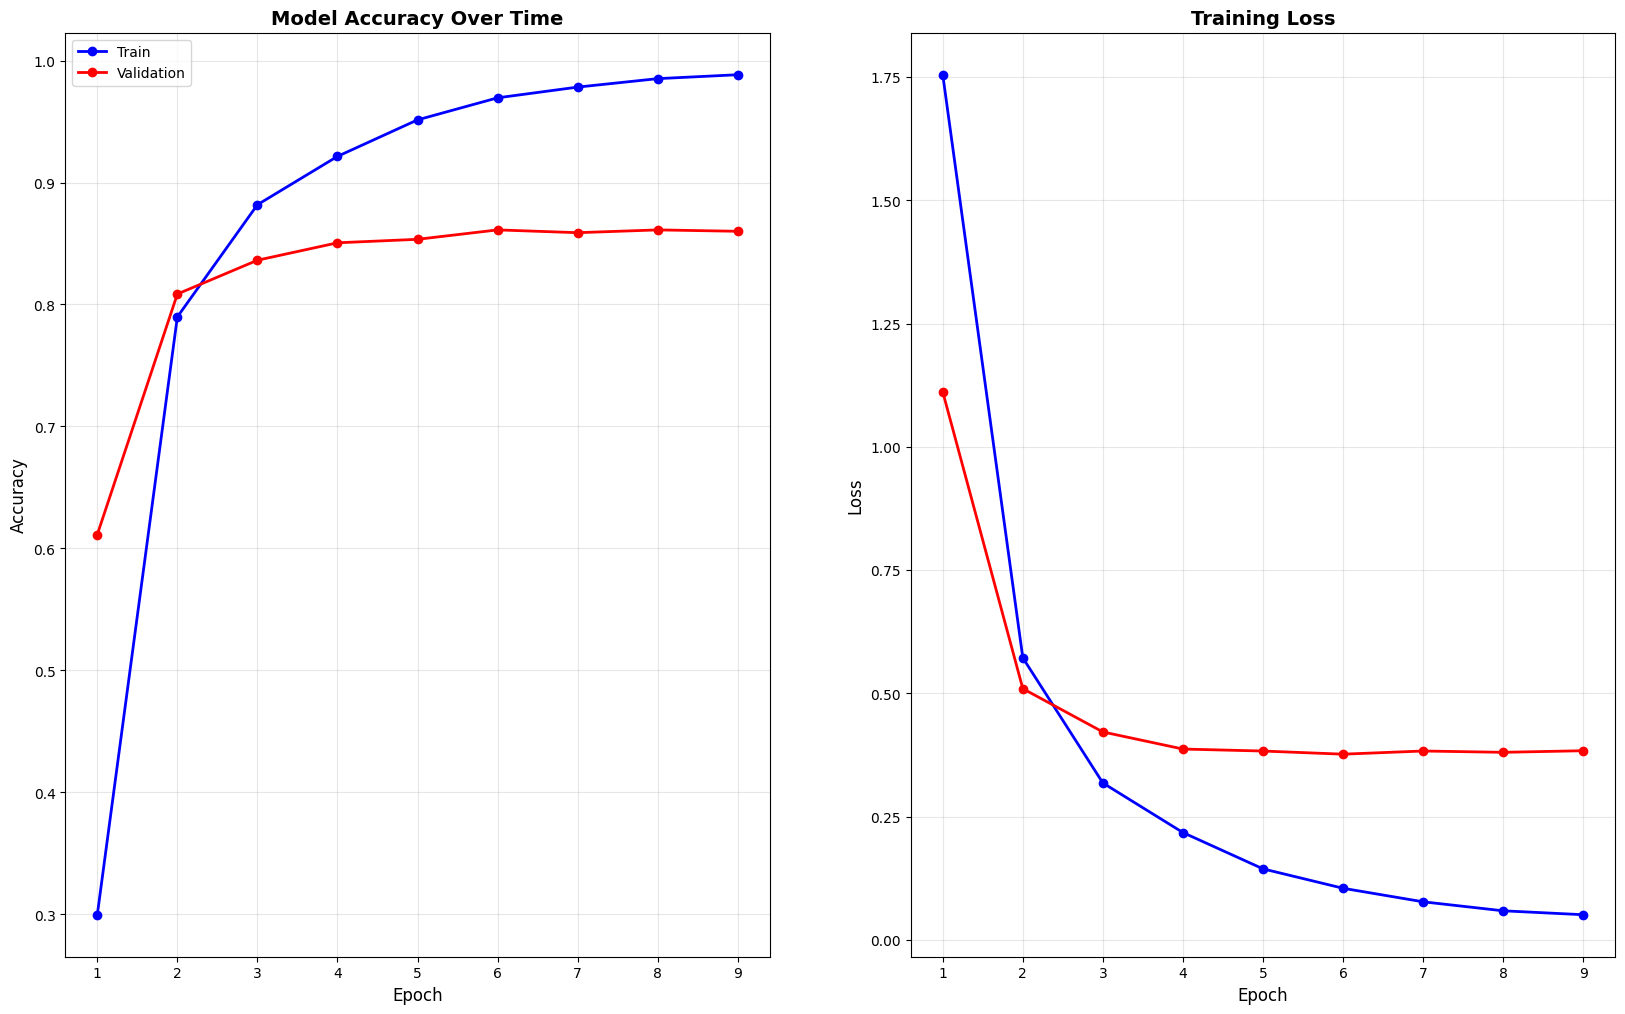

In [ ]:
# 1. accuracy curve
fig = plt.figure(figsize=(20, 12))

# # 1. Training History
ax1 = plt.subplot(1, 2, 1)
epochs_range = range(1, 10)
ax1.plot(epochs_range, train_accs, 'b-o', label='Train', linewidth=2)
ax1.plot(epochs_range, val_accs, 'r-o', label='Validation', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

 # 2. Loss Curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs_range, train_losses, 'b-o', linewidth=2)
ax2.plot(epochs_range, val_losses, 'r-o', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training Loss', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)


# 6. Load the best model from training to evaluate

In [ ]:
processor = AutoProcessor.from_pretrained(BEST_DIR)
model = AutoModelForImageClassification.from_pretrained(BEST_DIR).to(DEVICE)
model.eval()

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

# 7. Evaluate the performance of model in validation dataset

In [ ]:
print("\n" + "="*60)
print("Evaluation................")
print("="*60)


model.eval()

all_predictions = []
all_probabilities = []  # will become (N, C)
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(DEVICE)
        batch_y = batch_y.to(DEVICE)

        outputs = model(pixel_values=batch_X)
        probs = torch.softmax(outputs.logits, dim=1)   # (B, C)
        preds = outputs.logits.argmax(dim=1)           # (B,)

        all_probabilities.append(probs.cpu().numpy())
        all_predictions.append(preds.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())

all_probabilities = np.concatenate(all_probabilities, axis=0)  # (N, C=7)
all_predictions = np.concatenate(all_predictions, axis=0)      # (N,)
all_labels = np.concatenate(all_labels, axis=0)                # (N,)


Evaluation................


# 8. Results and Visualization

In [ ]:
# Performace metrics for all classes
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_predictions)
bacc = balanced_accuracy_score(all_labels, all_predictions)
f1_macro = f1_score(all_labels, all_predictions, average="macro")
f1_weighted = f1_score(all_labels, all_predictions, average="weighted")

print("Accuracy:", acc)
print("Balanced Acc:", bacc)
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)

cm = confusion_matrix(all_labels, all_predictions)
print("CM shape:", cm.shape)  # (7,7)

print(classification_report(all_labels, all_predictions, target_names=datasets_name, digits=4, zero_division=0))

Accuracy: 0.8611428571428571
Balanced Acc: 0.8611428571428571
F1 macro: 0.8607145830230511
F1 weighted: 0.8607145830230513
CM shape: (7, 7)
              precision    recall  f1-score   support

       glide     0.8897    0.7580    0.8186       500
  midjourney     0.9939    0.9740    0.9838       500
      wukong     0.9365    0.9440    0.9402       500
         adm     0.8099    0.9200    0.8614       500
        sdv5     0.7308    0.7600    0.7451       500
        vqdm     0.9237    0.9440    0.9337       500
      biggan     0.7568    0.7280    0.7421       500

    accuracy                         0.8611      3500
   macro avg     0.8630    0.8611    0.8607      3500
weighted avg     0.8630    0.8611    0.8607      3500



In [ ]:
# roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

C = all_probabilities.shape[1]
Y_true = label_binarize(all_labels, classes=list(range(C)))
auc_macro_ovr = roc_auc_score(Y_true, all_probabilities, multi_class="ovr", average="macro")
print("ROC-AUC macro (OvR):", auc_macro_ovr)

ROC-AUC macro (OvR): 0.9844404761904763


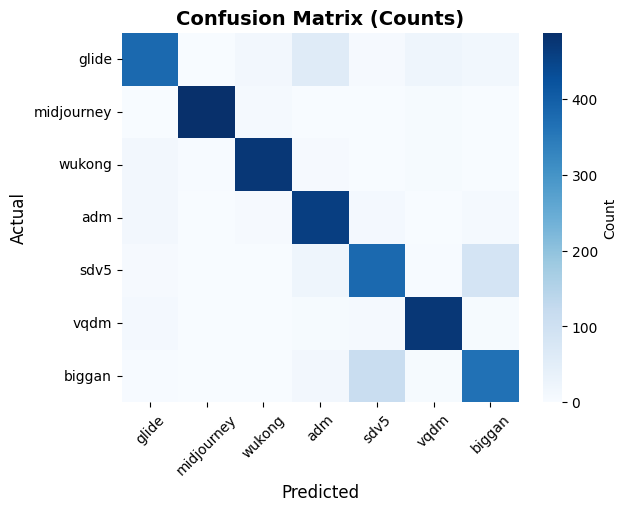

In [ ]:
# confusion matrix for all classes b
sns.heatmap(
    cm, annot=False, fmt='d', cmap='Blues',
    xticklabels=datasets_name, yticklabels=datasets_name,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tick_params(axis='x', rotation=45)

# 9. classify the unseen picture or batch

In [29]:
# get the image from url

def get_image(path):
    response = requests.get(url=path)
    img = Image.open(BytesIO(response.content))
    img = img.convert(mode="RGB")
    print(f"mode : {img.mode}")
    return img

import torch
from PIL import Image

def predict_image(path, val_tfms, model, device):
    # make sure model is in evaluation mode!
    model.eval()
    img = get_image(path)
    x = test_tfms(img).unsqueeze(0).to(device)  # (1,3,224,224)

    with torch.no_grad():
        logits = model(pixel_values=x).logits     # (1,C)
        print(logits)
        probs = torch.softmax(logits, dim=1)[0]    # (C,)
        print(probs)
        pred_id = int(probs.argmax().item())
        print(pred_id)
        pred_label = model.config.id2label[pred_id]
        confidence = float(probs[pred_id].item())

    return pred_label, confidence, probs.cpu().numpy()


In [30]:
mid_example = 'https://embracepresets.com/wp-content/uploads/2023/06/theart1300_Realistic_portrait_of_a_young_woman_with_sea-blue__93a47bc9-aebe-4a35-9249-f9bd564e3d88_2.png'

In [31]:
get_image(mid_example)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
label, conf, probs = predict_image(mid_example, val_tfms, model, DEVICE)
print("pred:", label, "conf:", conf)

mode : RGB
tensor([[-0.5016, -3.5232, -2.2927,  5.7148,  2.3676, -3.1235,  0.9484]],
       device='cuda:0')
tensor([1.9081e-03, 9.2967e-05, 3.1823e-04, 9.5578e-01, 3.3627e-02, 1.3865e-04,
        8.1343e-03], device='cuda:0')
3
pred: midjourney conf: 0.9557810425758362


# 10. Upload the model to Hugging Face model reposiotry and download from repository

In [ ]:
# Install packages
!pip install -q transformers huggingface_hub safetensors

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Load the processor and model for model uploading
processor = AutoProcessor.from_pretrained(BEST_DIR)
model = AutoModelForImageClassification.from_pretrained(BEST_DIR).to(DEVICE)

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
# push the model and processor to hugging face model repo
model.push_to_hub("gechen98/AI_image_generator_classification")
processor.push_to_hub("gechen98/AI_image_generator_classification")

README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ijql2c0/model.safetensors:  12%|#1        | 40.0MB /  343MB            

CommitInfo(commit_url='https://huggingface.co/gechen98/AI_image_generator_classification/commit/e9410919cb264652f37eea2dd8df48804be81528', commit_message='Upload processor', commit_description='', oid='e9410919cb264652f37eea2dd8df48804be81528', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gechen98/AI_image_generator_classification', endpoint='https://huggingface.co', repo_type='model', repo_id='gechen98/AI_image_generator_classification'), pr_revision=None, pr_num=None)

## 10.2 download the model from hugging face

In [4]:
# Down load the model from model repo directly
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "gechen98/AI_image_generator_classification"
)

print("Loaded successfully")

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Loaded successfully


In [7]:
# put the model to gpu if you are using.
model.to(DEVICE)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed